In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.optimizers as optimizers
from sklearn.preprocessing import OneHotEncoder
from deep_learning_models.get_dataset import get_feature_from_npy
from construct_factor_database.wind_db_result import WindSqlEngine
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,roc_curve, auc,classification_report
from scipy import stats
from keras.utils import plot_model
import seaborn as sns
from tqdm import tqdm
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# 获取数据集
data_all = get_feature_from_npy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2430/2430 [02:56<00:00, 13.75it/s]


In [3]:
#十年因子数据
data_all.shape

(7870932, 25)

In [4]:
#2013-2022有效数据(有label的数据)
data_to_model = data_all.dropna()
data_to_model.shape

(2152832, 25)

In [5]:
train_all=data_to_model[data_to_model['Date']<='2019-09-01']
test_all=data_to_model[data_to_model['Date']>='2020-01-01']
val_all=data_to_model[(data_to_model['Date']>'2019-09-01') & (data_to_model['Date']<='2020-01-01')]
print(train_all.shape)
print(test_all.shape)
print(val_all.shape)

(1191764, 25)
(821267, 25)
(78649, 25)


In [6]:
train_all.head()

,Date,Ticker,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,close,return_5,label
1,2013-01-04,000002.SZ,-0.965830,1.182998,0.947636,-0.002845,-0.665383,0.483191,0.220036,-0.515417,...,1.548047,0.318787,-0.101410,1.797035,-0.054150,-1.444809,-1.522456,1163.93,0.000,0.0
5,2013-01-04,000007.SZ,-1.512829,-1.164745,-2.465406,-0.773473,0.618476,-0.519624,-0.646017,-1.759949,...,-0.793496,0.693322,-1.355540,-0.539131,0.703258,0.677078,0.658477,78.84,0.132,1.0
7,2013-01-04,000011.SZ,-1.229412,-0.227101,-0.887079,1.254941,2.627087,0.576840,1.401817,-0.265266,...,-0.466465,-0.977753,-1.797352,1.464594,-2.017166,-1.630227,-0.968915,22.74,-0.051,-1.0
11,2013-01-04,000019.SZ,-0.764515,0.634445,0.430020,-0.088722,-0.565307,-0.105636,0.801835,0.028535,...,1.690449,-2.080887,-0.244009,2.730191,0.280410,-1.799952,-1.866064,16.69,0.000,0.0
15,2013-01-04,000024.SZ,-1.054044,0.408584,0.286493,1.106070,0.888920,0.236456,1.100890,0.937637,...,-0.317789,-0.462621,-1.426388,0.179909,-0.067518,-0.003551,-0.810374,159.67,-0.079,-1.0


In [7]:
def transfer_signal(df):
    Y = np.array(df['label'])
    encoder = OneHotEncoder(categories='auto')
    labels = Y.reshape(-1, 1)  # 将标签转换为二维数组
    y = encoder.fit_transform(labels).toarray()
    df=np.array(df[0])
    num_samples = df.shape[0]-20+1
    X_new = np.zeros((num_samples, 20, 20))
    y_new = np.zeros((num_samples, y.shape[1]))
    for i in range(num_samples):
        X_new[i] = df[i:i+20]
        y_new[i] = y[i+20-1] 
    return X_new,y_new

In [8]:
X_train, y_train = transfer_signal(train_all)
X_val, y_val = transfer_signal(val_all)
X_test, y_test=transfer_signal(test_all)
X_train = X_train.reshape(X_train.shape[0], 20, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 20, 1)
X_val = X_val.reshape(X_val.shape[0], 20, 20, 1)
print(X_train.shape,y_train.shape,X_val.shape, y_val.shape,X_test.shape, y_test.shape)

(1191745, 20, 20, 1) (1191745, 3) (78630, 20, 20, 1) (78630, 3) (821248, 20, 20, 1) (821248, 3)


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same', input_shape=(20,20,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 4), strides=(1, 4), padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 3), padding='same'),

    tf.keras.layers.Reshape((10, 32)),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(16,return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [10]:
plot_model(model, to_file='cnn_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 3, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 3, 32)         0

In [12]:
# 编译模型
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=5)

In [13]:
# 训练模型
history = model.fit(X_train, y_train, epochs=10 , batch_size=32, validation_data=(X_val, y_val), verbose=2,shuffle = 'True',callbacks=[early_stop])

Epoch 1/10
37243/37243 - 1013s - loss: 1.0755 - accuracy: 0.3973 - val_loss: 1.0223 - val_accuracy: 0.4723 - 1013s/epoch - 27ms/step
Epoch 2/10
37243/37243 - 973s - loss: 1.0532 - accuracy: 0.4336 - val_loss: 1.0129 - val_accuracy: 0.4818 - 973s/epoch - 26ms/step
Epoch 3/10
37243/37243 - 959s - loss: 1.0479 - accuracy: 0.4391 - val_loss: 1.0098 - val_accuracy: 0.4825 - 959s/epoch - 26ms/step
Epoch 4/10
37243/37243 - 942s - loss: 1.0448 - accuracy: 0.4422 - val_loss: 1.0031 - val_accuracy: 0.4880 - 942s/epoch - 25ms/step
Epoch 5/10
37243/37243 - 927s - loss: 1.0428 - accuracy: 0.4443 - val_loss: 0.9996 - val_accuracy: 0.4892 - 927s/epoch - 25ms/step
Epoch 6/10
37243/37243 - 921s - loss: 1.0410 - accuracy: 0.4464 - val_loss: 0.9984 - val_accuracy: 0.4892 - 921s/epoch - 25ms/step
Epoch 7/10
37243/37243 - 919s - loss: 1.0402 - accuracy: 0.4469 - val_loss: 0.9954 - val_accuracy: 0.4917 - 919s/epoch - 25ms/step
Epoch 8/10
37243/37243 - 924s - loss: 1.0391 - accuracy: 0.4486 - val_loss: 0.997

In [14]:
# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25664/25664 - 135s - loss: 1.0203 - accuracy: 0.4681 - 135s/epoch - 5ms/step
Test accuracy: 0.4680900275707245
Test loss: 1.020250678062439


In [15]:
#混淆矩阵验证
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_test_clsses =  np.argmax(y_test,axis=1)
confusion_mtx = confusion_matrix(y_true= y_test_clsses,y_pred = y_pred_classes)

25664/25664 [==============================] - 164s 6ms/step


Text(33.4375, 0.5, 'True Class')

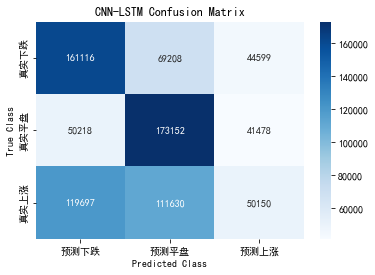

In [36]:
confusion_mtx_df=pd.DataFrame(confusion_mtx,index=['真实下跌', '真实平盘', '真实上涨'],columns=['预测下跌', '预测平盘', '预测上涨'])
sns.heatmap(confusion_mtx_df,annot=True, fmt='d',cmap='Blues')
plt.title('CNN-LSTM Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

In [17]:
print(classification_report(y_true= y_test_clsses,y_pred = y_pred_classes, target_names=['下跌', '平盘', '上涨']))

              precision    recall  f1-score   support

          下跌       0.49      0.59      0.53    274923
          平盘       0.49      0.65      0.56    264848
          上涨       0.37      0.18      0.24    281477

    accuracy                           0.47    821248
   macro avg       0.45      0.47      0.44    821248
weighted avg       0.45      0.47      0.44    821248



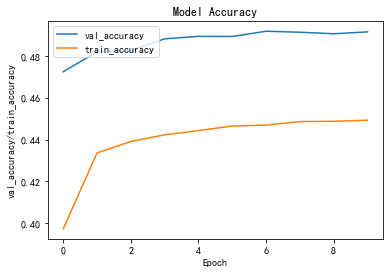

In [18]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('val_accuracy/train_accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'train_accuracy'], loc='upper left')
plt.show()

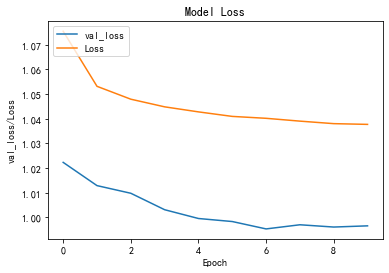

In [19]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('val_loss/train_loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'train_loss'], loc='upper left')
plt.show()

In [20]:
#基于backtrader回测

In [21]:
# 从mysql库里取涨停股数据 以及zz500指数数据
wind_conn = WindSqlEngine('20200101', '20230101')
uplimit_stocks = wind_conn.get_uplimit_stocks()
zz500_index  = wind_conn.get_zhongzheng_index()
uplimit_stocks['Date'] = pd.to_datetime(uplimit_stocks['Date'])
zz500_index['Date'] = pd.to_datetime(zz500_index['Date'])

In [22]:
uplimit_dict = uplimit_stocks.groupby('Date')['Ticker'].apply(list).to_dict()

In [23]:
y_pred.shape

(821248, 3)

In [24]:
price_data = data_all.loc[data_all['Date']>='2020-01-01',['Date','Ticker','close']]
price_data = pd.merge(price_data, uplimit_stocks, on=['Date', 'Ticker'], how='outer', indicator=True)
price_data = price_data[price_data['_merge'] == 'left_only'].drop(columns='_merge')

In [25]:
backtrade_df = test_all.iloc[:y_pred.shape[0],:]
backtrade_df.reset_index(inplace = True,drop = True)

In [26]:
max_up_prob=1-y_pred[:,0]
max_up_prob=pd.DataFrame(max_up_prob,columns = ['prob'])

In [27]:
result = pd.concat([backtrade_df[[ 'Date',  'Ticker',  'return_5']],max_up_prob],axis=1,ignore_index = True)
result.columns = [ 'Date',  'Ticker', 'return_5','prob']
result = pd.merge(price_data,result,how = 'left',on = [ 'Date',  'Ticker'])
result['return'] = result.groupby('Ticker')['close'].pct_change()

In [28]:
zz500_index['return'] = zz500_index.groupby('Ticker')['close'].pct_change()
zz500_index['cum_return'] = (1 + zz500_index['return']).cumprod()

In [29]:
result.shape

(2908759, 6)

In [30]:
def calculate_metrics(portfolio_returns, benchmark_returns, risk_free_rate=0.0, periods_per_year=252):
    # Calculate total return
    total_return = (portfolio_returns + 1).prod() - 1
    
    # Calculate benchmark total return
    benchmark_total_return = (benchmark_returns + 1).prod() - 1
    
    
    # Calculate annualized returns
    annualized_return = (1 + total_return) ** (periods_per_year / len(portfolio_returns)) - 1
    annualized_benchmark_return = (1 + benchmark_total_return) ** (periods_per_year / len(benchmark_returns)) - 1
    
    # Calculate volatility
    volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # Calculate annualized volatility
    annualized_volatility = volatility * np.sqrt(periods_per_year)
    annualized_benchmark_volatility = benchmark_volatility * np.sqrt(periods_per_year)
    # Calculate beta
    covariance_matrix = np.cov(portfolio_returns, benchmark_returns)

    beta = covariance_matrix[0][1] / covariance_matrix[1][1]
    # Calculate alpha
    alpha = annualized_return - (risk_free_rate + beta * (annualized_benchmark_return - risk_free_rate))
    
    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # Calculate Sortino ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.std(downside_returns)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation * np.sqrt(periods_per_year)
    
    # Calculate win rate
    win_rate = (portfolio_returns > 0).mean()
    
    # Calculate max drawdown
    cum_returns = (portfolio_returns + 1).cumprod()
    max_drawdown = (cum_returns.cummax() - cum_returns).max()
    
    # Format output as dictionary
    metrics = {
        'Total return': total_return,
        'Benchmark total return': benchmark_total_return,
        'Annualized return': annualized_return,
        'Annualized benchmark return': annualized_benchmark_return,
        'Annualized volatility': annualized_volatility,
        'Annualized benchmark volatility': annualized_benchmark_volatility,
        'Sharpe ratio': sharpe_ratio,
        'Sortino ratio': sortino_ratio,
        'Win rate': win_rate,
        'Max drawdown': max_drawdown,
        'alpha':alpha,
        'Beta':beta
    }
    
    return metrics


In [31]:
def backtest(data,initial_capital=1000000, transaction_cost=0.0012):
    
    # 计算每个交易日选出的前10只股票
    data=data[~data['Ticker'].str.startswith(('688', '300'))]
    dates=list(data['Date'].unique())
    dates_predict = dates[::5]
    data['prob'] = data['prob'].fillna(0)
    # 根据前一天的数据取最大概率前10的股票
    df_buy = data.groupby('Date').apply(lambda x:x.shift(1).nlargest(10, 'prob')).reset_index(drop=True)
    df_buy = df_buy[~df_buy['prob'].isna()]
#   df_predict 每天选出的前n只股票
#   holdings 每天持仓股情况
    holdings = pd.DataFrame(index =list(data['Date'].unique()),columns = range(10),data = np.nan)

    for dt in dates_predict:
        tickers = list(df_buy[df_buy['Date']==dt]['Ticker'])
        holdings.loc[dt,:] = tickers
    holdings=holdings.fillna(method='ffill')
    holdings.to_csv(f'C://Users//LYQ//Desktop//parquet_data//cnn-lstm_holdings.csv')
    df_all= pd.DataFrame(index = holdings.index)
    for dt in tqdm(holdings.index):
        if dt==holdings.index[0]:
            df_all['capital'] = initial_capital
        else:
            today_ticker = list(holdings.loc[dt,:])
            if dt in dates_predict:
                df_all.loc[dt,'daily_return'] = data.loc[(data['Date'] == dt) & (data['Ticker'].isin(today_ticker)), 'return'].mean()-transaction_cost
            else:
                df_all.loc[dt,'daily_return'] = data.loc[(data['Date'] == dt) & (data['Ticker'].isin(today_ticker)), 'return'].mean()
            df_all.loc[dt,'capital']= df_all['capital'].shift(1)[dt] *(1+df_all.loc[dt,'daily_return'])
    df_all['cum_return'] = (1 + df_all['daily_return']).cumprod()
    return df_all

In [32]:
df_profit = backtest(result,initial_capital=1000000, transaction_cost=0.0012)
print(df_profit)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 728/728 [01:04<00:00, 11.35it/s]

                 capital  daily_return  cum_return
2020-01-02  1.000000e+06           NaN         NaN
2020-01-03  9.959958e+05     -0.004004    0.995996
2020-01-06  1.000775e+06      0.004798    1.000775
2020-01-07  1.009769e+06      0.008987    1.009769
2020-01-08  1.009020e+06     -0.000741    1.009020
...                  ...           ...         ...
2022-12-26  3.331817e+06     -0.000849    3.331817
2022-12-27  3.328433e+06     -0.001016    3.328433
2022-12-28  3.358779e+06      0.009117    3.358779
2022-12-29  3.257154e+06     -0.030256    3.257154
2022-12-30  3.293755e+06      0.011237    3.293755

[728 rows x 3 columns]


In [81]:
performance_metrics = calculate_metrics(df_profit['daily_return'].fillna(0), zz500_index['return'].fillna(0))
a = pd.DataFrame(performance_metrics,index=['CNN-LSTM'],columns =['Total return','Benchmark total return','Annualized return','Annualized benchmark return','Annualized volatility','Annualized benchmark volatility','Sharpe ratio', 'Sortino ratio', 'Win rate','Max drawdown','alpha','Beta']).T
a.to_csv(f'C://Users//LYQ//Desktop//single_factor_report//cnn_lstm_metrics.csv')

In [84]:
performance_metrics_benchmark = calculate_metrics(zz500_index['return'].fillna(0), zz500_index['return'].fillna(0))
b = pd.DataFrame(performance_metrics_benchmark,index=['benchmark'],columns =['Total return','Benchmark total return','Annualized return','Annualized benchmark return','Annualized volatility','Annualized benchmark volatility','Sharpe ratio', 'Sortino ratio', 'Win rate','Max drawdown','alpha','Beta']).T
b.to_csv(f'C://Users//LYQ//Desktop//single_factor_report//benchmark_metrics.csv')

In [41]:
cnn_return= pd.read_csv(f'C://Users//LYQ//Desktop//single_factor_report//cnn_return.csv')
lstm_return = pd.read_csv(f'C://Users//LYQ//Desktop//single_factor_report//lstm_return.csv')
cnn_return =cnn_return['cum_return']
lstm_return =lstm_return['cum_return']

In [ ]:
df_profit.reset_index(inplace = True)

In [55]:
return_all = pd.concat([df_profit,cnn_return,lstm_return],axis=1,ignore_index = True)

In [58]:
return_all.columns = ['Date','capital', 'daily_return','cnn-lstm','cnn','lstm']

In [60]:
return_all

,Date,capital,daily_return,cnn-lstm,cnn,lstm
0,2020-01-02,1.000000e+06,NaN,NaN,NaN,NaN
1,2020-01-03,9.959958e+05,-0.004004,0.995996,1.004721,0.996192
2,2020-01-06,1.000775e+06,0.004798,1.000775,0.999881,0.995291
3,2020-01-07,1.009769e+06,0.008987,1.009769,1.011439,1.002773
4,2020-01-08,1.009020e+06,-0.000741,1.009020,1.010647,0.980781
...,...,...,...,...,...,...
723,2022-12-26,3.331817e+06,-0.000849,3.331817,2.047007,2.618783
724,2022-12-27,3.328433e+06,-0.001016,3.328433,2.081777,2.645376
725,2022-12-28,3.358779e+06,0.009117,3.358779,2.100757,2.669495
726,2022-12-29,3.257154e+06,-0.030256,3.257154,2.037196,2.588726


In [49]:
df_profit.reset_index(inplace = True)

In [ ]:
#8ECFC9
#FFBE7A
#FA7F6F
#82B0D2
#BEB8DC
#E7DAD2

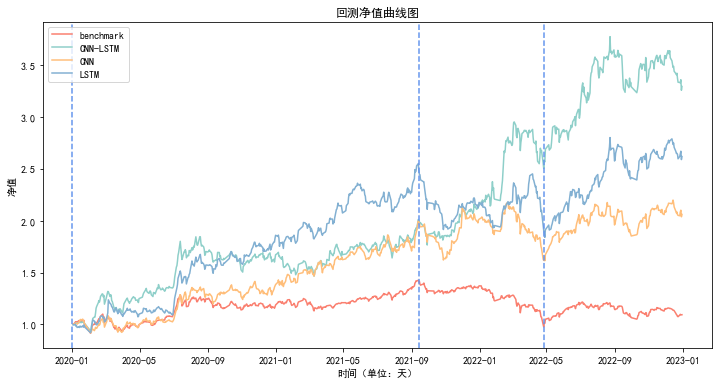

In [85]:
plt.figure(figsize=(12, 6))
# （0,44,83）-（255,165,16）-（12,132,198）-（255,189,102）-（247,77,77）-（36,85,164）-（65,183,172）
plt.plot(zz500_index['Date'], zz500_index['cum_return'], color='#FA7F6F', label='benchmark')
plt.plot(return_all['Date'], return_all['cnn-lstm'], color='#8ECFC9', label='CNN-LSTM')
plt.plot(return_all['Date'], return_all['cnn'], color='#FFBE7A', label='CNN')
plt.plot(return_all['Date'], return_all['lstm'], color='#82B0D2', label='LSTM')

plt.axvline(x=['2020-01-01'], ls='--',color='cornflowerblue')
plt.axvline(x=['2021-09-14'], ls='--',color='cornflowerblue')
plt.axvline(x=['2022-04-27'], ls='--',color='cornflowerblue')


plt.title('回测净值曲线图')
plt.xlabel('时间（单位：天）')
plt.ylabel('净值')
plt.legend(loc='upper left')